# Refactored Script: MultiView/MultiWavelength

In [1]:
#imports
import shdom
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
os.chdir('/Users/jesserl2/Documents/Code/aviad_pyshdom_dev/pyshdom_dev')

from collections import OrderedDict

# Define the Medium

Decide on the individual scatterers and decide on the RTE grid that will be used.
This must be done before sensor definition in the case of orthographic sensors
and will also help decide general sensor pointing directions etc so should be the first step.

Some utility functions from shdom.grid are used to combine the grids but these could be defined arbitrarily.

All of the workflow, including this first step is based on the use of SHDOM.

In [2]:
#load a cloud.
#locate the 'origin' of the cloud at 0.0,0.0 for simplicity.
#this option allows us to easily move individual clouds with respect to each other
#and even if overlapping they will be merged onto the RTE grid.
cloud_scatterer = shdom.grid.load_from_csv('./synthetic_cloud_fields/jpl_les/rico32x37x26.txt', 
                                           density='lwc',origin=(0.0,0.0))

#load atmosphere file for rayleigh. (and eventually gases)
#'Altitude' coordinate is renamed to 'z'.
atmosphere = xr.open_dataset('./ancillary_data/AFGL_summer_mid_lat.nc').rename(Altitude='z')

#extract a chosen temperature_profile and the surface_pressure.
#only model atmosphere below 20 km. This choice needs to be made here so
#that an RTE grid can be defined.
reduced_atmosphere = atmosphere.sel({'z': atmosphere.coords['z'].data[atmosphere.coords['z'].data <= 1.0]})

# -----  make the RTE grid ---------------------------

#make RTE grid just using cloud_scatterer for horizontal grid and 'merged' z coordinates.
merged_z_coordinate = shdom.grid.combine_z_coordinates([reduced_atmosphere,cloud_scatterer])

#simple 'union' horizontal grid merging for 3D and 1D needs to be fixed.
rte_grid = shdom.grid.make_grid(cloud_scatterer.x.data.min(),cloud_scatterer.x.data.max(),cloud_scatterer.x.data.size,
                           cloud_scatterer.y.data.min(),cloud_scatterer.y.data.max(),cloud_scatterer.y.data.size,
                           merged_z_coordinate)



# Define the Sensors

Individual sensors should be added and appended to a list. Any combination can be created.
To illustrate a little of the variety we have an idealization of a MISR/MODIS or MSPI/eMAS type configuration with multi-view VIS and nadir-view multi-spectral.

In [3]:
#This is modified by the user as needed.

#idealized monochromatic orthographic sensors at different wavelengths.
#9 'MISR-like' VIS cameras
#1  'MODIS-like' nadir multi-spectral sensor.

sensor_list = []

#add MISR-like sensors
sensor_zenith_list = [70.6,60.0,45.6,26.1,26.1,45.6,60.0,70.6]
sensor_azimuth_list = [90,90,90,90,-90,-90,-90,-90]

for zenith,azimuth in zip(sensor_zenith_list,sensor_azimuth_list):
    sensor_list.append(
        shdom.sensor.add_sub_pixel_rays(shdom.sensor.orthographic_projection(0.66, rte_grid,0.02,0.02, azimuth, zenith,
                                             altitude='TOA', stokes='I'
                                            ),0.0)
    
    )
  
#add MODIS-like sensors
wavelength_list = [0.66, 1.65,2.17]
for wavelength in wavelength_list:
    sensor_list.append(
        shdom.sensor.add_sub_pixel_rays(shdom.sensor.orthographic_projection(wavelength,rte_grid,0.02,0.02,0.0,0.0,
                                            altitude='TOA',
                                            stokes='I'
                                            ),0.0)
    )

# Define the Number of SHDOM solvers.

Here we need to choose the type (number of stokes components) and number (for different wavelengths) of SHDOM solvers. In this case we only have monochromatic sensors so the choice of SHDOMs is very simple and can be fixed/reused code. 
The number of SHDOM solvers could be defined based on other unique criteria such as arbitrary combinations of different sources/surfaces or scatterers. Scripts of that form can easily be adapted from this.
This is the most common desired workflow as all RTE solvers at different wavelengths correspond to the same physical situation.


In [4]:
#num_stokes should be set to choose whether to use num_stokes=USER_SPECIFIED
#even if only radiance needs to be simulated for accuracy reasons.
num_stokes_override_flag = False
num_stokes_override=3

#extract all unique_wavelengths
#this treats even very slightly different wavelengths as unique.
wavelengths = np.unique([sensor.wavelength for sensor in sensor_list])

#From here everything is now ordered dicts for traceability of which solver each entry corresponds to,
#(with wavelength as the unique identifier).
#Other unique identifiers coould be used.

num_stokes = OrderedDict()
rte_sensors = OrderedDict()

for wavelength in wavelengths:
    sensor_list_wavelength = []
    for sensor in sensor_list:
        if sensor.wavelength == wavelength:
            if sensor.stokes[3]:
                min_stokes = 4
            elif sensor.stokes[1] or sensor.stokes[2]:
                min_stokes = 3
            elif sensor.stokes[0]:
                min_stokes = 1
            if (num_stokes_override_flag) & (min_stokes < num_stokes_override):
                min_stokes = num_stokes_override
            num_stokes[wavelength] = min_stokes
            
            sensor_list_wavelength.append(sensor)
    rte_sensors[wavelength] = sensor_list_wavelength
                

# Define Other RTE inputs.

These are determined by the unique identifier which is wavelength in this case.
For simplicity all other inputs are wavelength invariant.

In [5]:
names = OrderedDict()
surfaces = OrderedDict()
sources = OrderedDict()
numerical_parameters = OrderedDict()

for wavelength in wavelengths:
    names[wavelength] = None
    surfaces[wavelength] = shdom.surface.fixed_lambertian_surface(albedo=0.01) #surface is wavelength independent.
    sources[wavelength] = shdom.source.solar_source(145.0,0.0,solarflux=1.0)
    numerical_parameters[wavelength] = shdom.configuration.get_config('./default_config.json') #all use defaults.
     

# Define Scatterer Optical Properties

In this case we only have one mie scatterer. Each type of scatterer should be explicitly treated with its own section here.

This is a key component of the 'set_state' workflow.



In [6]:
#resample the cloud onto the rte_grid
cloud_scatterer_on_rte_grid = shdom.grid.resample_onto_grid(rte_grid, cloud_scatterer)

#define any necessary variables for microphysics here.
size_distribution_function = shdom.size_distribution.gamma
#We choose a gamma size distribution and therefore need to define a 'veff' variable.
cloud_scatterer_on_rte_grid['veff'] = (cloud_scatterer_on_rte_grid.reff.dims, 
                                       np.full_like(cloud_scatterer_on_rte_grid.reff.data, fill_value=0.1))

#calculate the optical properties for this scatterer.
#All wavelengths use consistent settings.
cloud_optical_scatterers = OrderedDict()
for wavelength in wavelengths:
    print('making mie_table. . . may take a while.')
    mie_mono_table = shdom.mie.get_mono_table('Water',(wavelength,wavelength)) 
    cloud_size_distribution = shdom.size_distribution.get_size_distribution_grid(
                                                            mie_mono_table.radius.data,
                        size_distribution_function=shdom.size_distribution.gamma,particle_density=1.0,
                        reff=[4.0,25.0,25,'logarithmic','micron'],
                        veff=[0.09,0.11,2,'linear','unitless'],                                                                               
                        )
    poly_table = shdom.mie.get_poly_table(cloud_size_distribution,mie_mono_table)
    cloud_optical_scatterers[wavelength] = shdom.medium.table_to_grid(cloud_scatterer_on_rte_grid, poly_table)
    

making mie_table. . . may take a while.
making mie_table. . . may take a while.
making mie_table. . . may take a while.


# Define Rayleigh Optical Properties

In [7]:
#get rayleigh.
#This is self contained due to its simplicity.
rayleigh_scatterer_list = shdom.rayleigh.to_grid(wavelengths,atmosphere,rte_grid)



In [8]:
#group properties 
mediums = OrderedDict()
for key,optical in cloud_optical_scatterers.items():
    
    rayleigh = rayleigh_scatterer_list[key]
    mediums[key] = [optical]#, rayleigh]
    
    
    

In [9]:
#make solver list
solvers = OrderedDict()

for key,name in names.items():
    solvers[key] = shdom.solver.RTE(numerical_params=numerical_parameters[key], 
                                    medium=mediums[key],
                                   source=sources[key],
                                   surface=surfaces[key],
                                    num_stokes=num_stokes[key],
                                    name=name
                                   )

In [10]:
#solver list can be distributed in parallel or in serial for solution
#the solved solvers are modified inplace and can be found in solvers.
for solver in solvers.values():
    solver.solve(maxiter=100)

In [13]:
observables = OrderedDict()
for key,sensors in rte_sensors.items():
    merged_sensor_rays = shdom.sensor.merge_sensor_rays(sensors)
    rendered_rays = shdom.sensor.split_sensor_rays(solvers[key].integrate_to_sensor(merged_sensor_rays))
    observable = [shdom.sensor.get_observables(sensor,rendered_ray) for sensor,rendered_ray in zip(sensors, rendered_rays)]
    observables[key] = observable



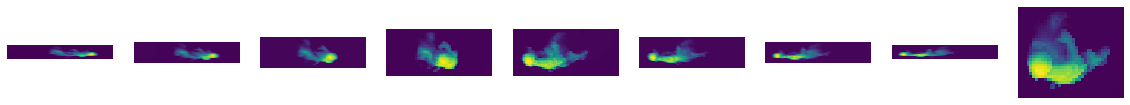

In [24]:
#get VIS images

images = [observable.I.data.reshape(observable.image_shape.data,order='F') for observable in observables[0.66]]

%matplotlib inline
f, axarr = plt.subplots(1, len(images), figsize=(20, 20))
for ax, image in zip(axarr, images):
    ax.imshow(image)
    ax.invert_xaxis() 
    ax.invert_yaxis() 
    ax.axis('off')
    
